In [ ]:
!pip install tisthemachinelearner

In [2]:
%load_ext rpy2.ipython

In [ ]:
%%R

install.packages("reticulate")


library(reticulate)
library(MASS)


# 2. Import Python modules (with convert = FALSE for fine control)
sklearn_metrics <- import("sklearn.metrics", convert = TRUE)
tisthemachinelearner <- import("tisthemachinelearner")

In [4]:
%%R

df <- read.csv("https://raw.githubusercontent.com/Techtonique/datasets/refs/heads/main/tabular/regression/boston_dataset2.csv")

In [5]:
%%R

head(df)

       V0 V1   V2 V3    V4    V5   V6     V7 V8  V9  V10    V11  V12 target
1 0.00632 18 2.31  0 0.538 6.575 65.2 4.0900  1 296 15.3 396.90 4.98   24.0
2 0.02731  0 7.07  0 0.469 6.421 78.9 4.9671  2 242 17.8 396.90 9.14   21.6
3 0.02729  0 7.07  0 0.469 7.185 61.1 4.9671  2 242 17.8 392.83 4.03   34.7
4 0.03237  0 2.18  0 0.458 6.998 45.8 6.0622  3 222 18.7 394.63 2.94   33.4
5 0.06905  0 2.18  0 0.458 7.147 54.2 6.0622  3 222 18.7 396.90 5.33   36.2
6 0.02985  0 2.18  0 0.458 6.430 58.7 6.0622  3 222 18.7 394.12 5.21   28.7
  training_index
1              0
2              1
3              0
4              1
5              1
6              1


In [6]:
%%R

# 3. Prepare Boston dataset
idx <- which(df$training_index == 1)
X_train <- as.matrix(df[idx, seq_len(13)])
y_train <- df$target[idx]
X_test <- as.matrix(df[-idx, seq_len(13)])
y_test <- df$target[-idx]


In [13]:
%%R

# 5. Build and train model
model <- tisthemachinelearner$FiniteDiffRegressor(
  base_model = "GradientBoostingRegressor",
  lr = 0.01,
  optimizer = "gd"
)

# Convert R matrices/vectors to Python numpy arrays
X_train_py_list <- reticulate::r_to_py(X_train)
y_train_py_list <- reticulate::r_to_py(y_train)
X_test_py_list <- reticulate::r_to_py(X_test)
y_test_py_list <- reticulate::r_to_py(y_test)

# Pass Python numpy arrays to the Python model
model$fit(X_train_py_list, y_train_py_list, epochs=5L, show_progress = TRUE)

# 6. Predict and evaluate
y_pred <- model$predict(X_test_py_list)
# Ensure y_test_py (the Python object) is used, not y_test (the R vector)
# Now we should also convert y_test to a Python numpy array for the metric calculation
mse <- sqrt(sklearn_metrics$mean_squared_error(y_test_py_list, y_pred))

# 7. Display results
cat("Test MSE:", mse, "\n")

 20%|██        | 1/5 [00:00<00:00,  4.07it/s]

Epoch 1: Loss = 1.311296


 40%|████      | 2/5 [00:00<00:00,  4.26it/s]

Epoch 2: Loss = 1.311061


 60%|██████    | 3/5 [00:00<00:00,  4.18it/s]

Epoch 3: Loss = 1.313594


 80%|████████  | 4/5 [00:00<00:00,  4.28it/s]

Epoch 4: Loss = 1.315979


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

Epoch 5: Loss = 1.315979
Test MSE: 2.771768 


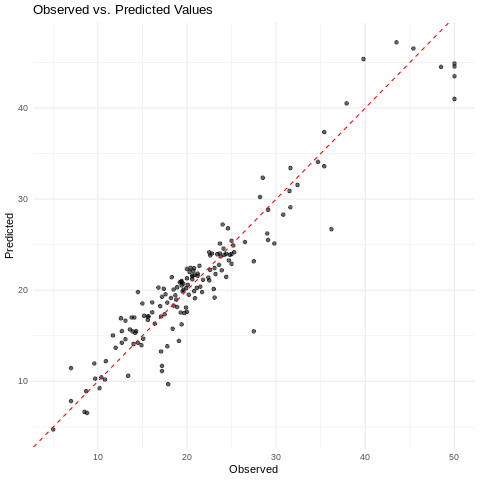

In [15]:
%%R

library(ggplot2)

# Create a dataframe for plotting
plot_data <- data.frame(Observed = y_test, Predicted = py_to_r(y_pred))

# Generate the scatterplot
ggplot(plot_data, aes(x = Observed, y = Predicted)) +
  geom_point(alpha = 0.6) +  # Use some transparency for overlapping points
  geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") + # Add y=x line
  theme_minimal() + # Use a minimal theme
  labs(title = "Observed vs. Predicted Values",
       x = "Observed",
       y = "Predicted")